<a href="https://colab.research.google.com/github/nribot/smoking/blob/main/Smoking_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instrucciones
* Leer archivo con los datos
* Preprocesado de los datos: eleimiar columnos que no nos interesen, limpiar * valores perdidos, cambiar etiqueta de las clases a 0, 1, 2, 3, .... en caso de * que sean strings, codificar o transformar columnas que sean texto, ....
* Separar entre X e Y
* Separar en entrenamiento y test (si no nos lo dan por defecto)
* Normalizar
* Entrenar los modelos que queramos de clasificación: Predicciones, evaluación * (alguna métrica de clasificación que hemos visto o varias de ellas)
* Comparar los resultados de todos los modeos y quedarnos con el mejor.
* Añadir validación cruzada a los hiperparámetros que considere oportuno!!!

In [2]:
# Para visualizar gráficas en notebooks
%matplotlib inline

# Para acceder al archivo guardado en drive
from google.colab import drive

# Librerías utilizadas
import random
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns

## Carga de datos


Datos obtenidos de https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking

La variable de salida es `smoking` que tiene dos valores en este dataset, según la documentación:
* 0 = no han fumado nunca
* 1 = fumaban anteriormente (pero ya no)

Había una tercera categoría, fumadores activos, que se ha eliminado ya del dataset.

In [2]:
#import kaggle
#! kaggle datasets download gauravduttakiit/cassava-leaf-disease-classificatio

In [3]:
drive.mount('/content/drive')

data = pd.read_csv('drive/MyDrive/Datasets/smoking.csv')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ID gender  age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0      F   40         155          60       81.3             1.2   
1   1      F   40         160          60       81.0             0.8   
2   2      M   55         170          60       80.0             0.8   
3   3      M   40         165          70       88.0             1.5   
4   4      F   40         155          60       86.0             1.0   

   eyesight(right)  hearing(left)  hearing(right)  ...  hemoglobin  \
0              1.0            1.0             1.0  ...        12.9   
1              0.6            1.0             1.0  ...        12.7   
2              0.8            1.0             1.0  ...        15.8   
3              1.5            1.0             1.0  ...        14.7   
4              1.0            1.0             1.0  ...        12.5   

   Urine protein  serum creatinine   AST   ALT   Gtp  oral  dental caries  \
0            1.0               0.7  18.0  19.0  27.0     Y              0   
1            1.0               0.6  22.0  19.0  18.0     Y              0   
2            1.0               1.0  21.0  16.0  22.0     Y              0   
3            1.0               1.0  19.0  26.0  18.0     Y              0   
4            1.0               0.6  16.0  14.0  22.0     Y              0   

   tartar  smoking  
0       Y        0  
1       Y        0  
2       N        1  
3       Y        0  
4       N        0  

[5 rows x 27 columns]

In [4]:
original_dim = data.shape
print("El dataset contiene", data.shape[0], "observaciones de", data.shape[1], "variables.")

El dataset contiene 55692 observaciones de 27 variables.


Examinamos el tipo de las columnas y si hay nulos:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

Eliminamos la variable `ID`

In [6]:
data = data.drop(labels=['ID'], axis=1)

## Examen y tranformación de los datos

### Variables categóricas

Visualizamos las columnas categóricas, incluyendo la variable de salida.

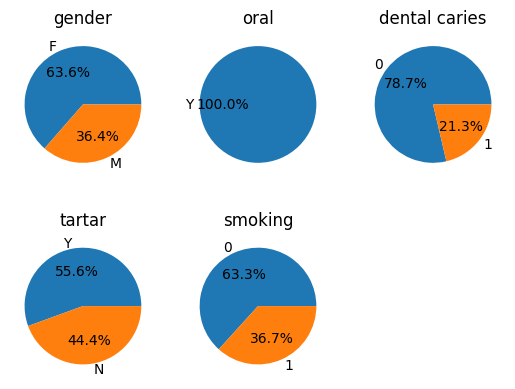

In [7]:
categorical = ['gender', 'oral', 'dental caries', 'tartar', 'smoking']

for i in categorical:
  idx = categorical.index(i)
  ax1 = plt.subplot(2,3, idx+1)
  ax1.pie(data[i].value_counts(),
          labels=data[i].unique(),
          autopct = '%1.1f%%'
          )
  ax1.set_title(i)

Vemos que la categoría `oral` no nos aporta información ya que todos las observaciones tienes la misma respuesta, la eliminamos.

In [8]:
data = data.drop(labels=['oral'], axis=1)
data.shape

(55692, 25)

Las columnas 'gender' y 'tartar' solo contienen dos categorías; las cambiamos a variables numéricas.

* Gender: 0 = male, 1 = female
* Tartar  0 = N, 1 = Y

In [9]:
data['gender'].replace('M', 0, inplace=True)
data['gender'].replace('F', 1, inplace=True)
data.replace('N', 0, inplace=True)
data.replace('Y', 1, inplace=True)
#data.loc[:,['gender', 'tartar']].head()

Además, vemos que el dataset tiene mucha más presencia de personas no fumadoras y de mujeres, vamos a examinar si hay alguna relación.

In [10]:
CrosstabResult=pd.crosstab(index=data['gender'],columns=data['smoking'])
print(CrosstabResult)

smoking      0      1
gender               
0        15805  19596
1        19432    859


In [11]:
np.corrcoef(data['smoking'], data['gender'])

array([[ 1.        , -0.51033967],
       [-0.51033967,  1.        ]])

Parece que sí hay una clara distribución por sexo: la gran mayoría de fumadores previos son hombres.

### Variables numéricas
Examinamos ahora las variables numéricas.

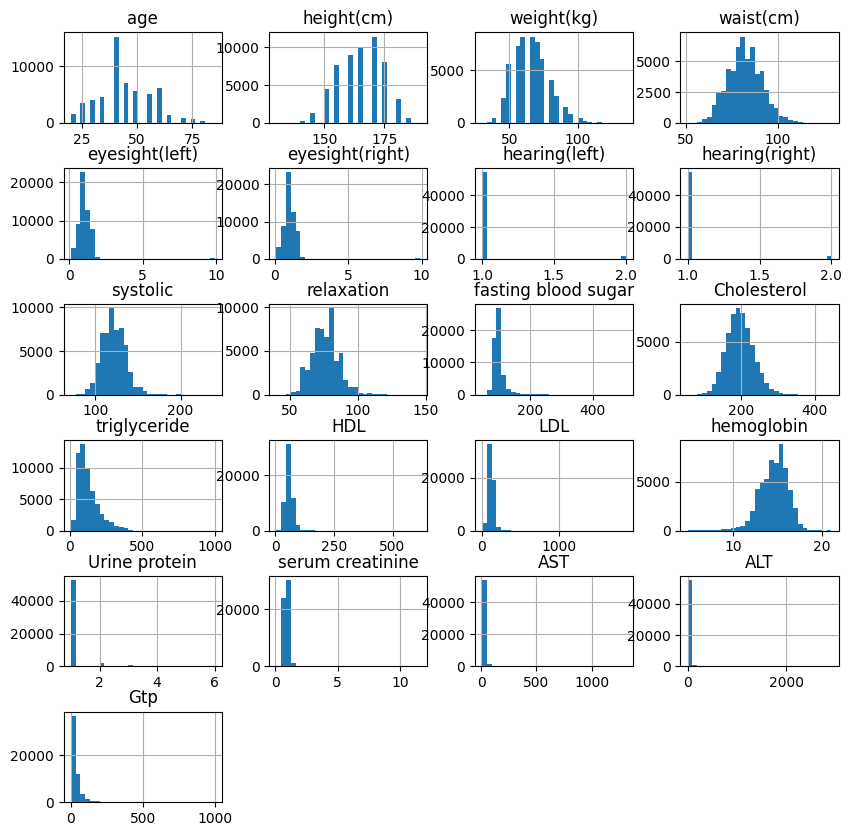

In [12]:
# separamos las variables numéricas
datanum = data.loc[:, ~data.columns.isin(categorical)]

datanum.hist(bins=30, layout = (6,4), figsize=(10, 10));
plt.subplots_adjust(hspace=0.5)
plt.show()

Observamos que hay muchas características que tienen la mayoría de observaciones concentradas en la izquierda: eso se debe a que habrá algunas observaciones con valores muy altos que hagan que el histograma se desplace a la izquierda.

Si visualizamos los datos con un gráfico de caja (en inglés boxplot o whiskers plot), podremos ver donde están concentrados los valores - en la caja - y los valores atípicos - con puntos.

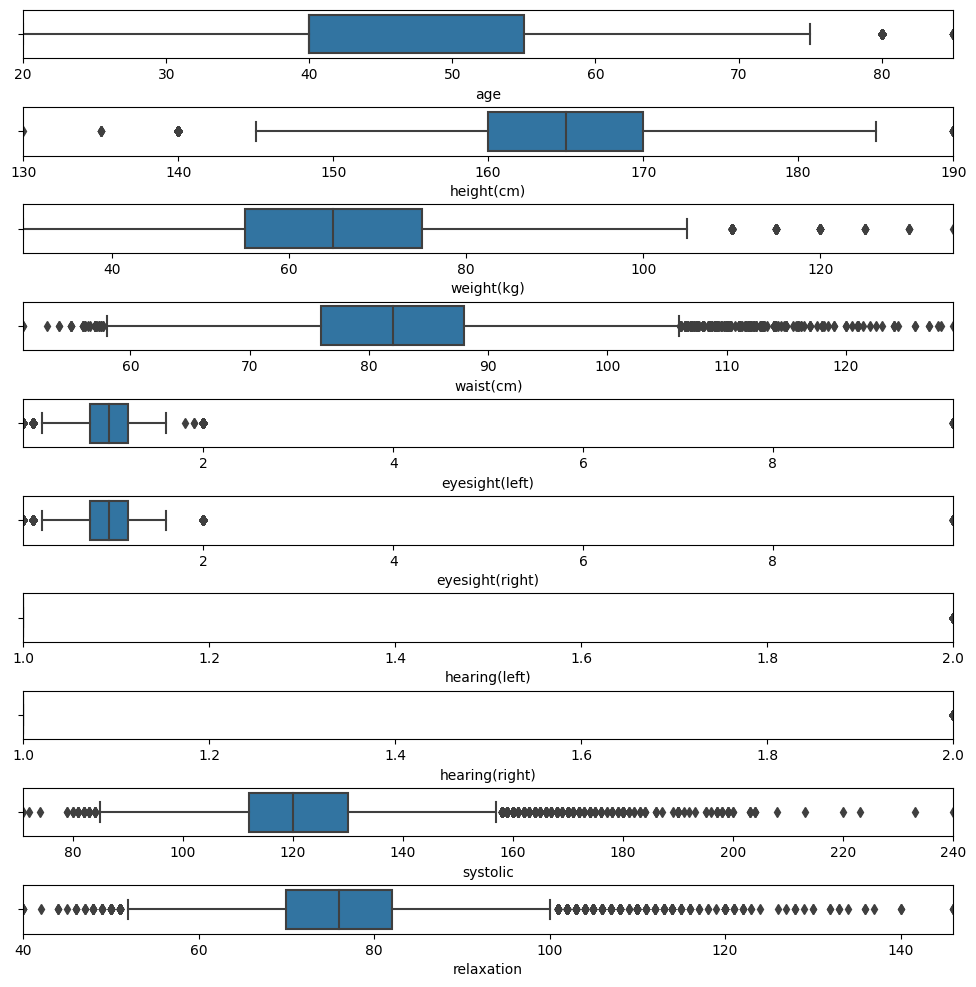

In [13]:
# obtenemos las columnas numéricas
cols = list(datanum.columns)

# repartimos en dos gráficos
half_length = len(cols) // 2
col1, col2 = cols[:half_length], cols[half_length:]


# boxplot with a different y scale for different rows (part1)
fig, axes = plt.subplots(len(col1), 1, figsize=(12,12))
plt.subplots_adjust(hspace=1)
# plotting a boxplot for every variable
for i, col in enumerate(col1):
    ax = sns.boxplot(x=data[col], ax=axes.flatten()[i])
    ax.set_xlim(data[col].min(), data[col].max())
plt.show()


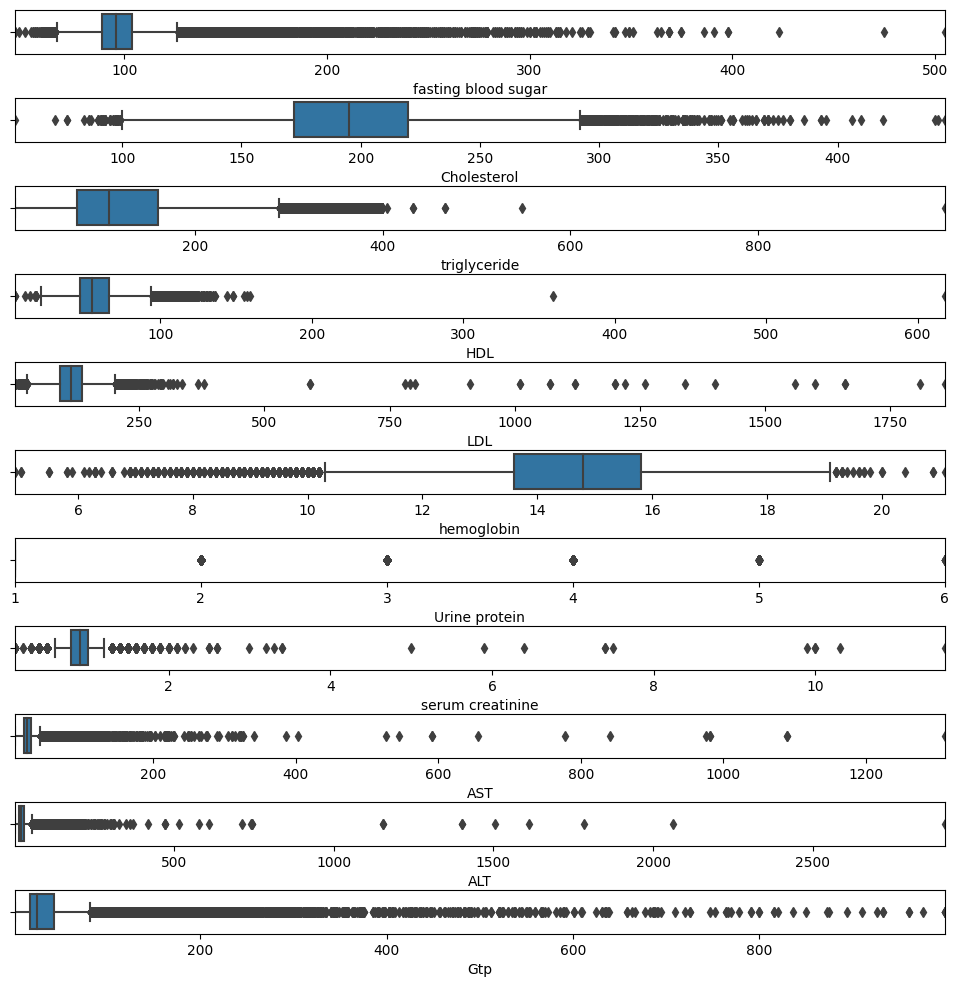

In [14]:
fig, axes = plt.subplots(len(col2), 1, figsize=(12,12))
plt.subplots_adjust(hspace=1)
for i, col in enumerate(col2):
    ax = sns.boxplot(x=data[col], ax=axes.flatten()[i])
    ax.set_xlim(data[col].min(), data[col].max())
plt.show()

La mayoría de variables presentan valores atípicos pero que están cerca unos de otros (se agrupan). La explicación más probable es que las cajas, que representan los valores más comunes, el rango intercuartílico, representan los valores normales de los pacientes sanos, mientras que los pacientes enfermos presentan valores más elevados (o bajos, en el caso de la hemoglobina).

### Distribución de las variables según la clase

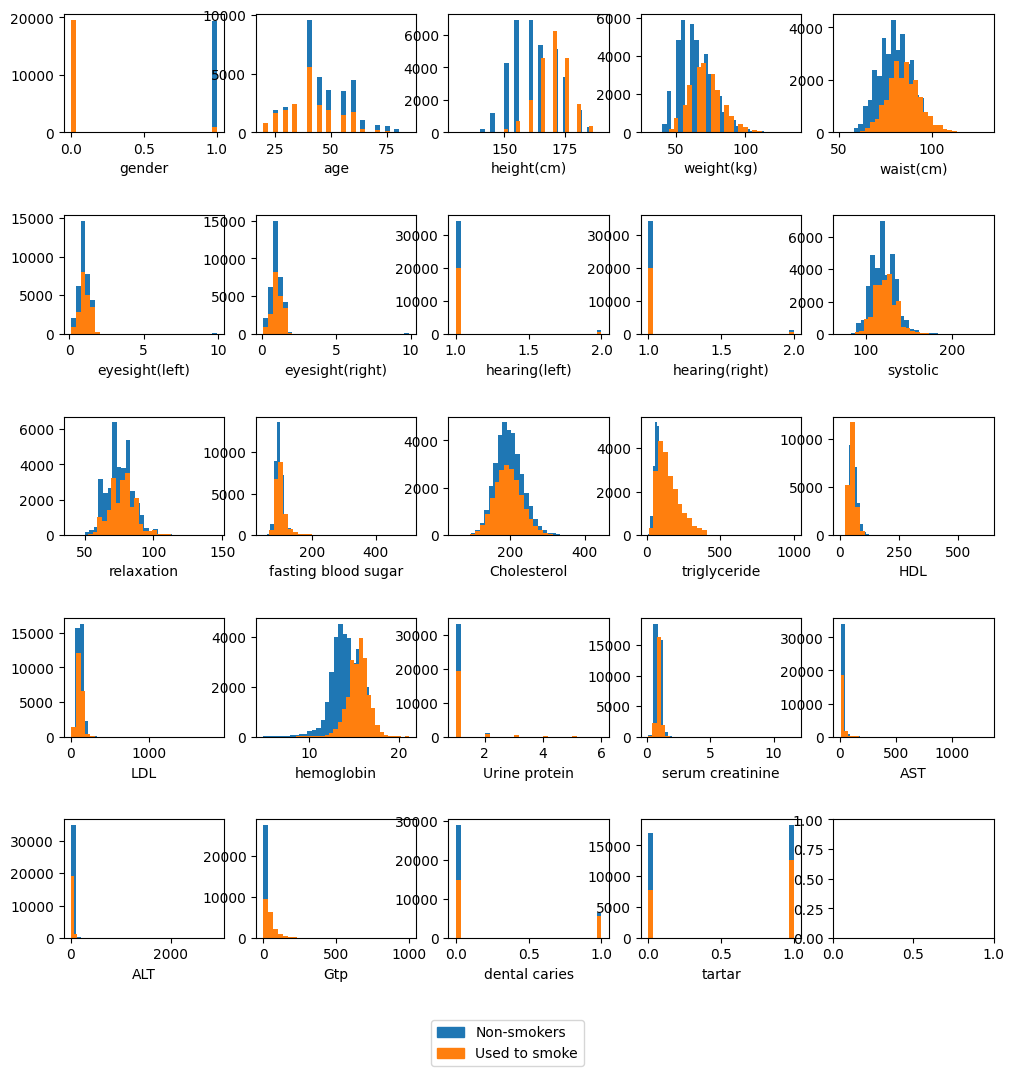

In [15]:
cols = list(data.columns)
# we eliminate the last column, containing the smoking group
cols.pop()

# GRAPH
# creating a figure with 5x5 subplots
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(12,12))
plt.subplots_adjust(hspace=0.7)

# plotting a histogram for every column
for i in range(len(cols)):
    r=i//5
    c=i%5
    data.groupby("smoking")[cols[i]].hist(ax=ax[r,c], bins=30)
    ax[r,c].set_xlabel(cols[i])
    ax[r,c].grid()

# legend
handle = [Patch(facecolor='C0', edgecolor='C0'), # colors
          Patch(facecolor='C1', edgecolor='C1')]
labels = ['Non-smokers', 'Used to smoke'] # labels of the groups
fig.legend(handle, labels, loc='lower center')

plt.show()

Podemos apreciar una variación clara según el hecho de fumar en las categorías de sexo (y las relacionadas con el dimorfismo sexual, como la altura y el peso), pero también en las variables `'triglyceride'`, `'hemoglobin'`, `'urine protein'` (los valores altos solo se encuentan en los ex-fumadores), `'Gtp'`, `'dental caries'` y `'tartar'`.

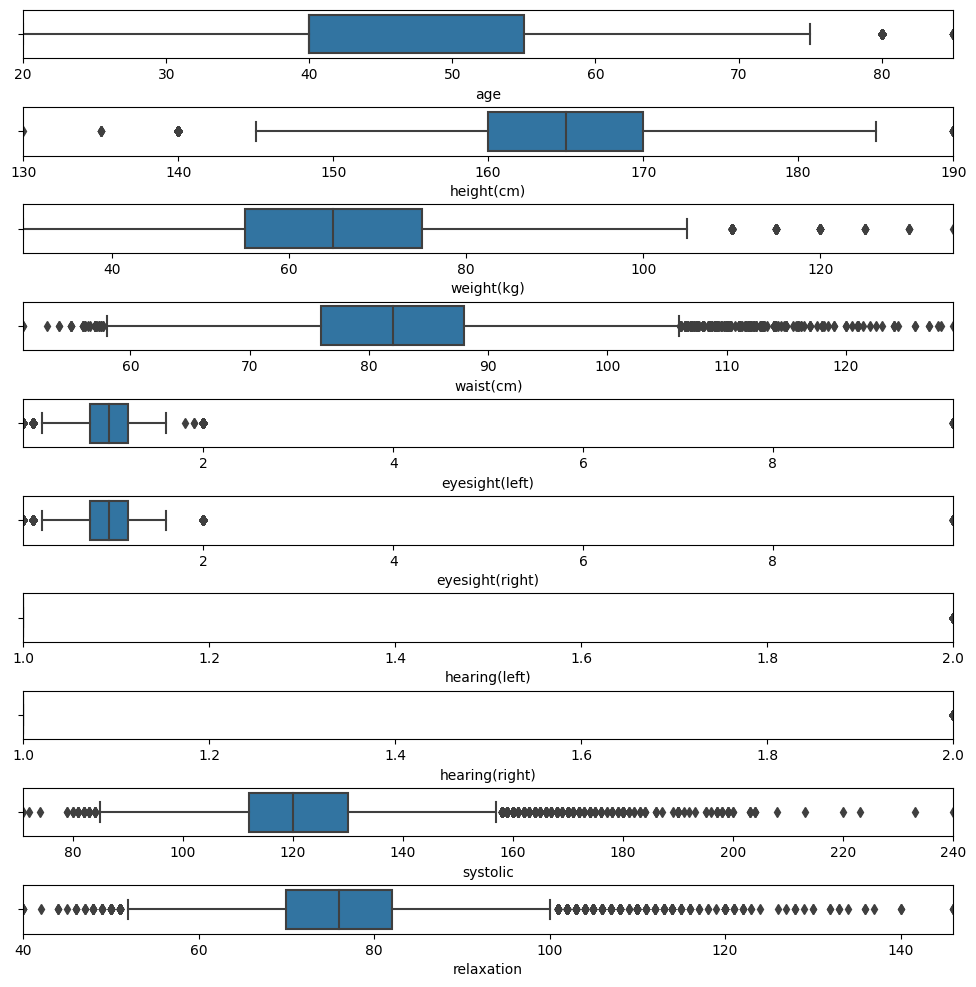

In [16]:
# obtenemos las columnas numéricas
cols = list(datanum.columns)

# repartimos en dos gráficos
half_length = len(cols) // 2
col1, col2 = cols[:half_length], cols[half_length:]


# boxplot with a different y scale for different rows (part1)
fig, axes = plt.subplots(len(col1), 1, figsize=(12,12))
plt.subplots_adjust(hspace=1)
# plotting a boxplot for every variable
for i, col in enumerate(col1):
    ax = sns.boxplot(x=data[col], hue = data['smoking'], ax=axes.flatten()[i])
    ax.set_xlim(data[col].min(), data[col].max())
plt.show()

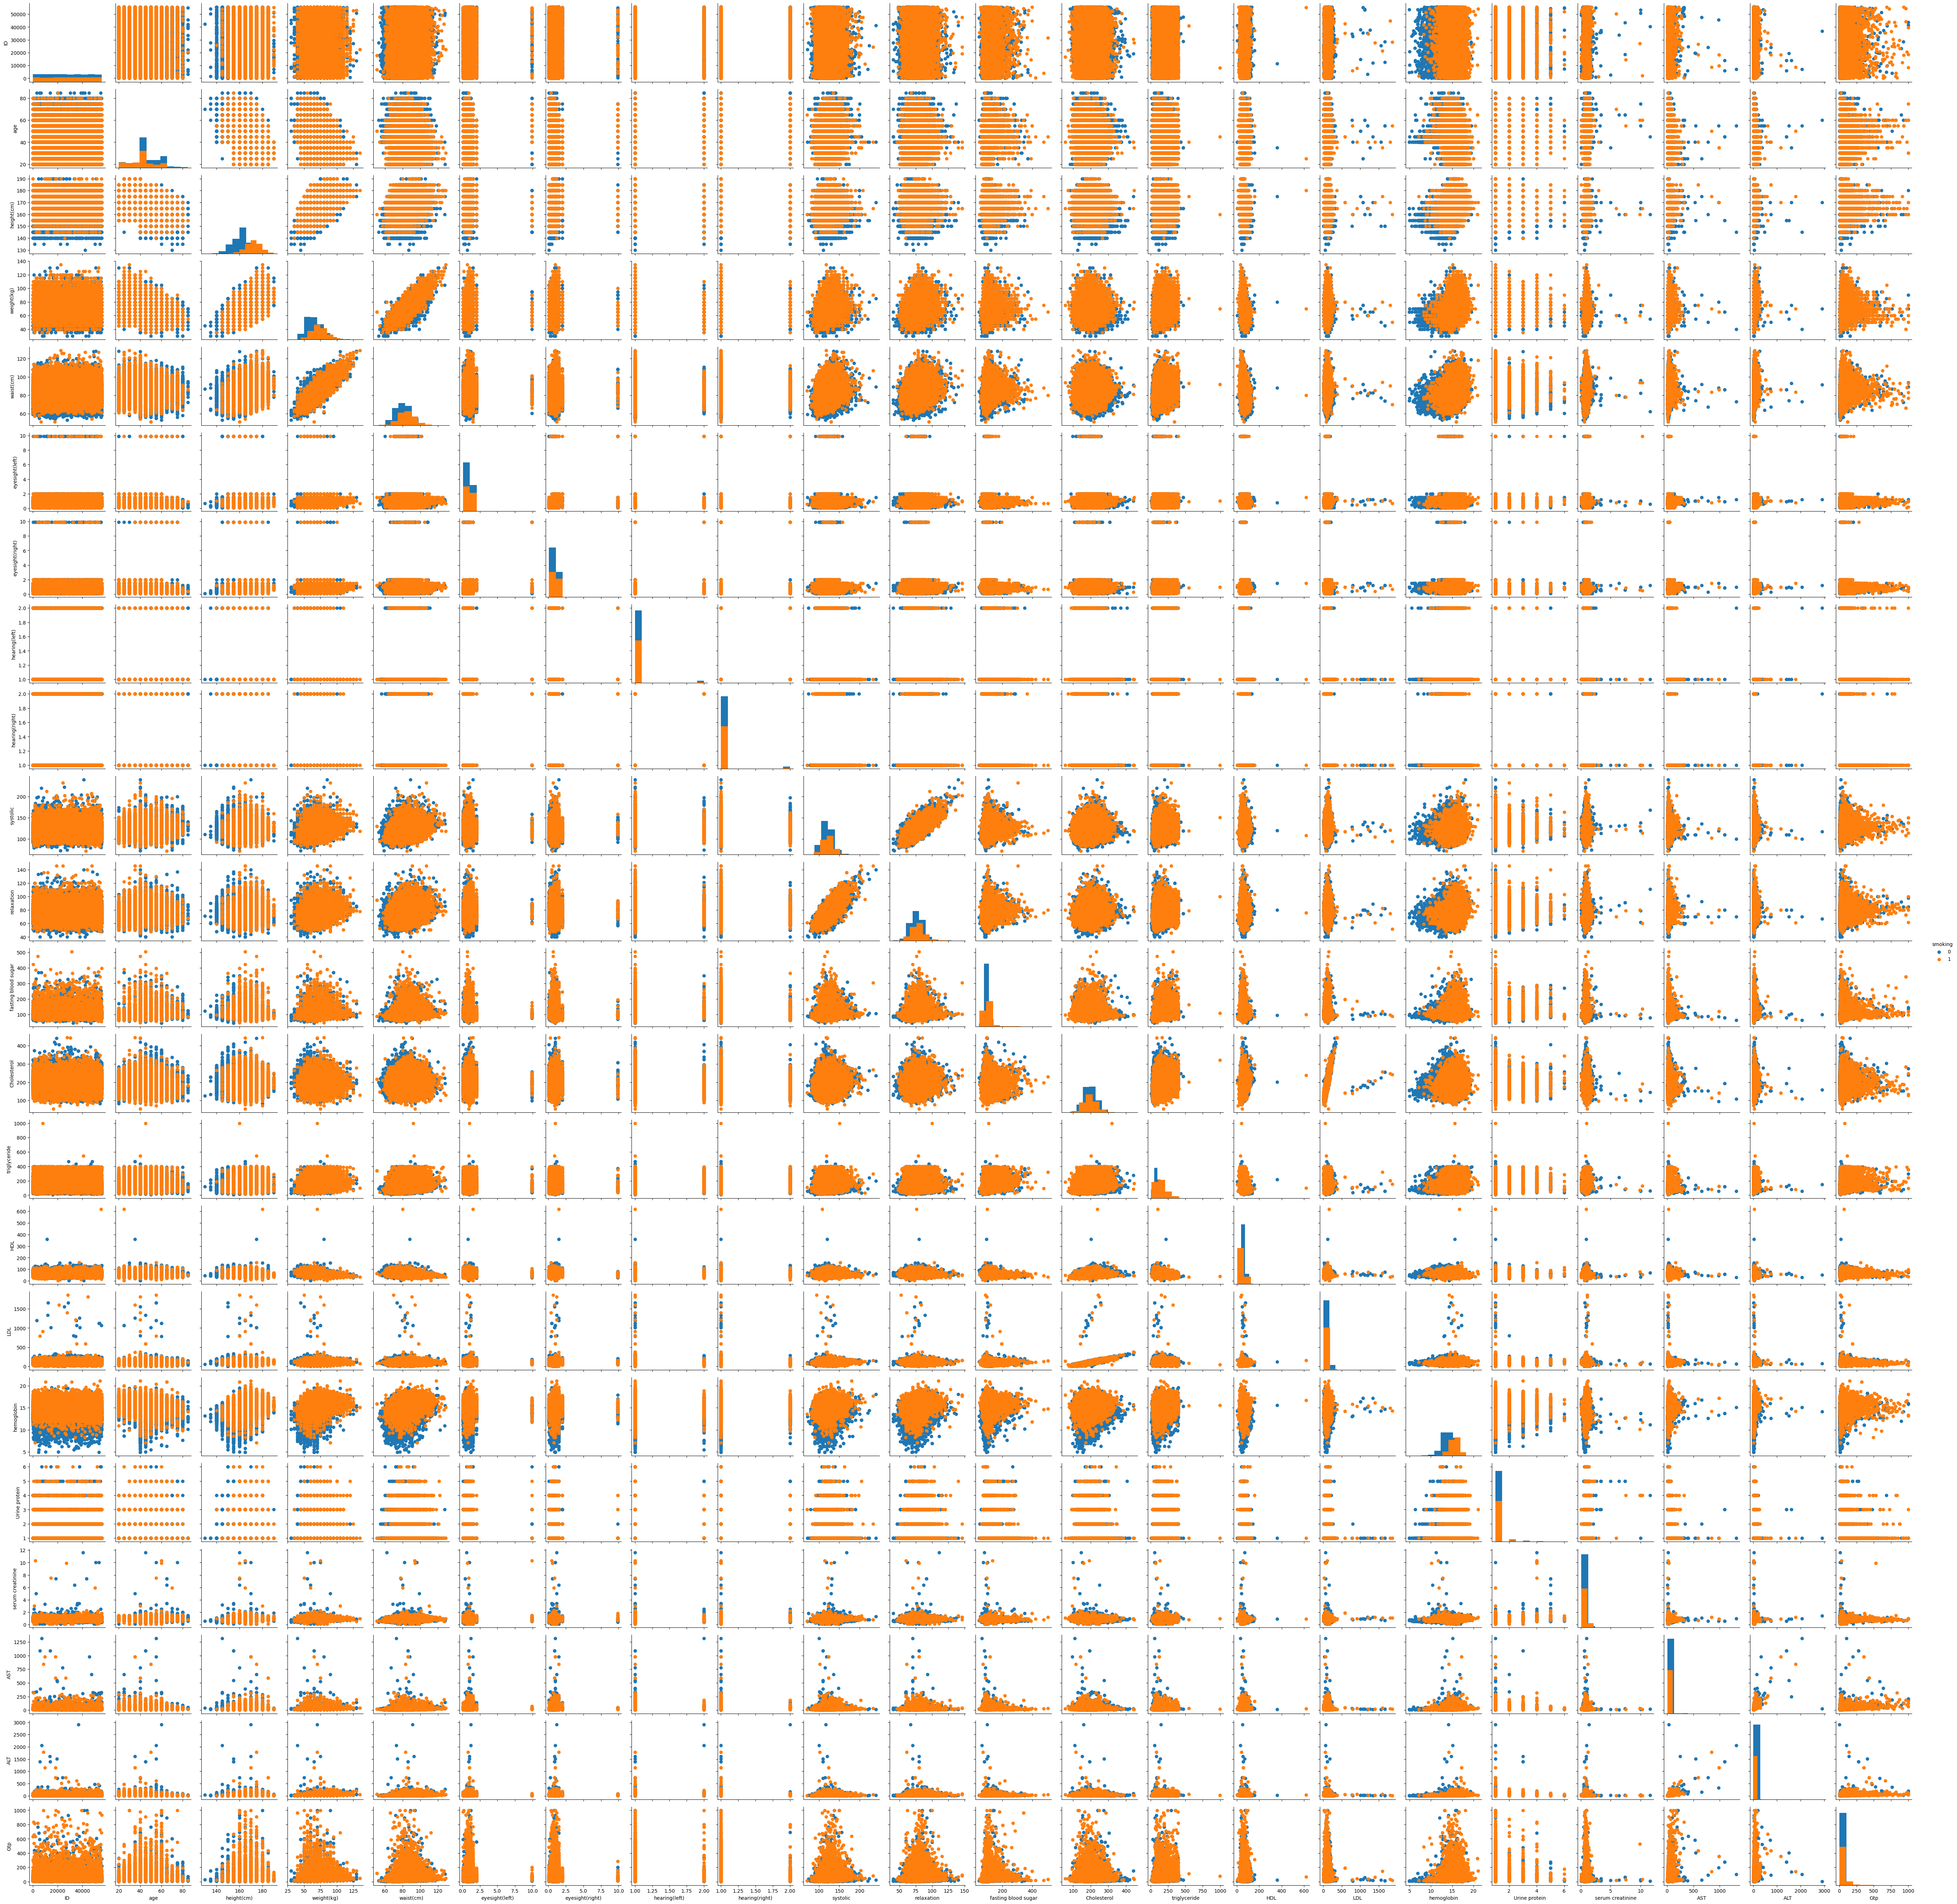

In [4]:
data2 = data.drop(labels=['gender', 'dental caries', 'tartar'], axis=1)
# PairGrid object with hue
graph = sns.PairGrid(data2, hue ='smoking')
# type of graph for diagonal
graph = graph.map_diag(plt.hist)
# type of graph for non-diagonal
graph = graph.map_offdiag(plt.scatter)
# to add legends
graph = graph.add_legend()
# to show
plt.show()